<a href="https://colab.research.google.com/github/hamer101/Brownian-motion/blob/main/lab/10_CNN_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sieci konwolucyjne część 2.

**Uwaga:** Poniższy notebook jest stworzony z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip,
                                    ToTensor)

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

100%|██████████| 170498071/170498071 [00:04<00:00, 40372227.87it/s]


Extracting ./cifar-10-python.tar.gz to .
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


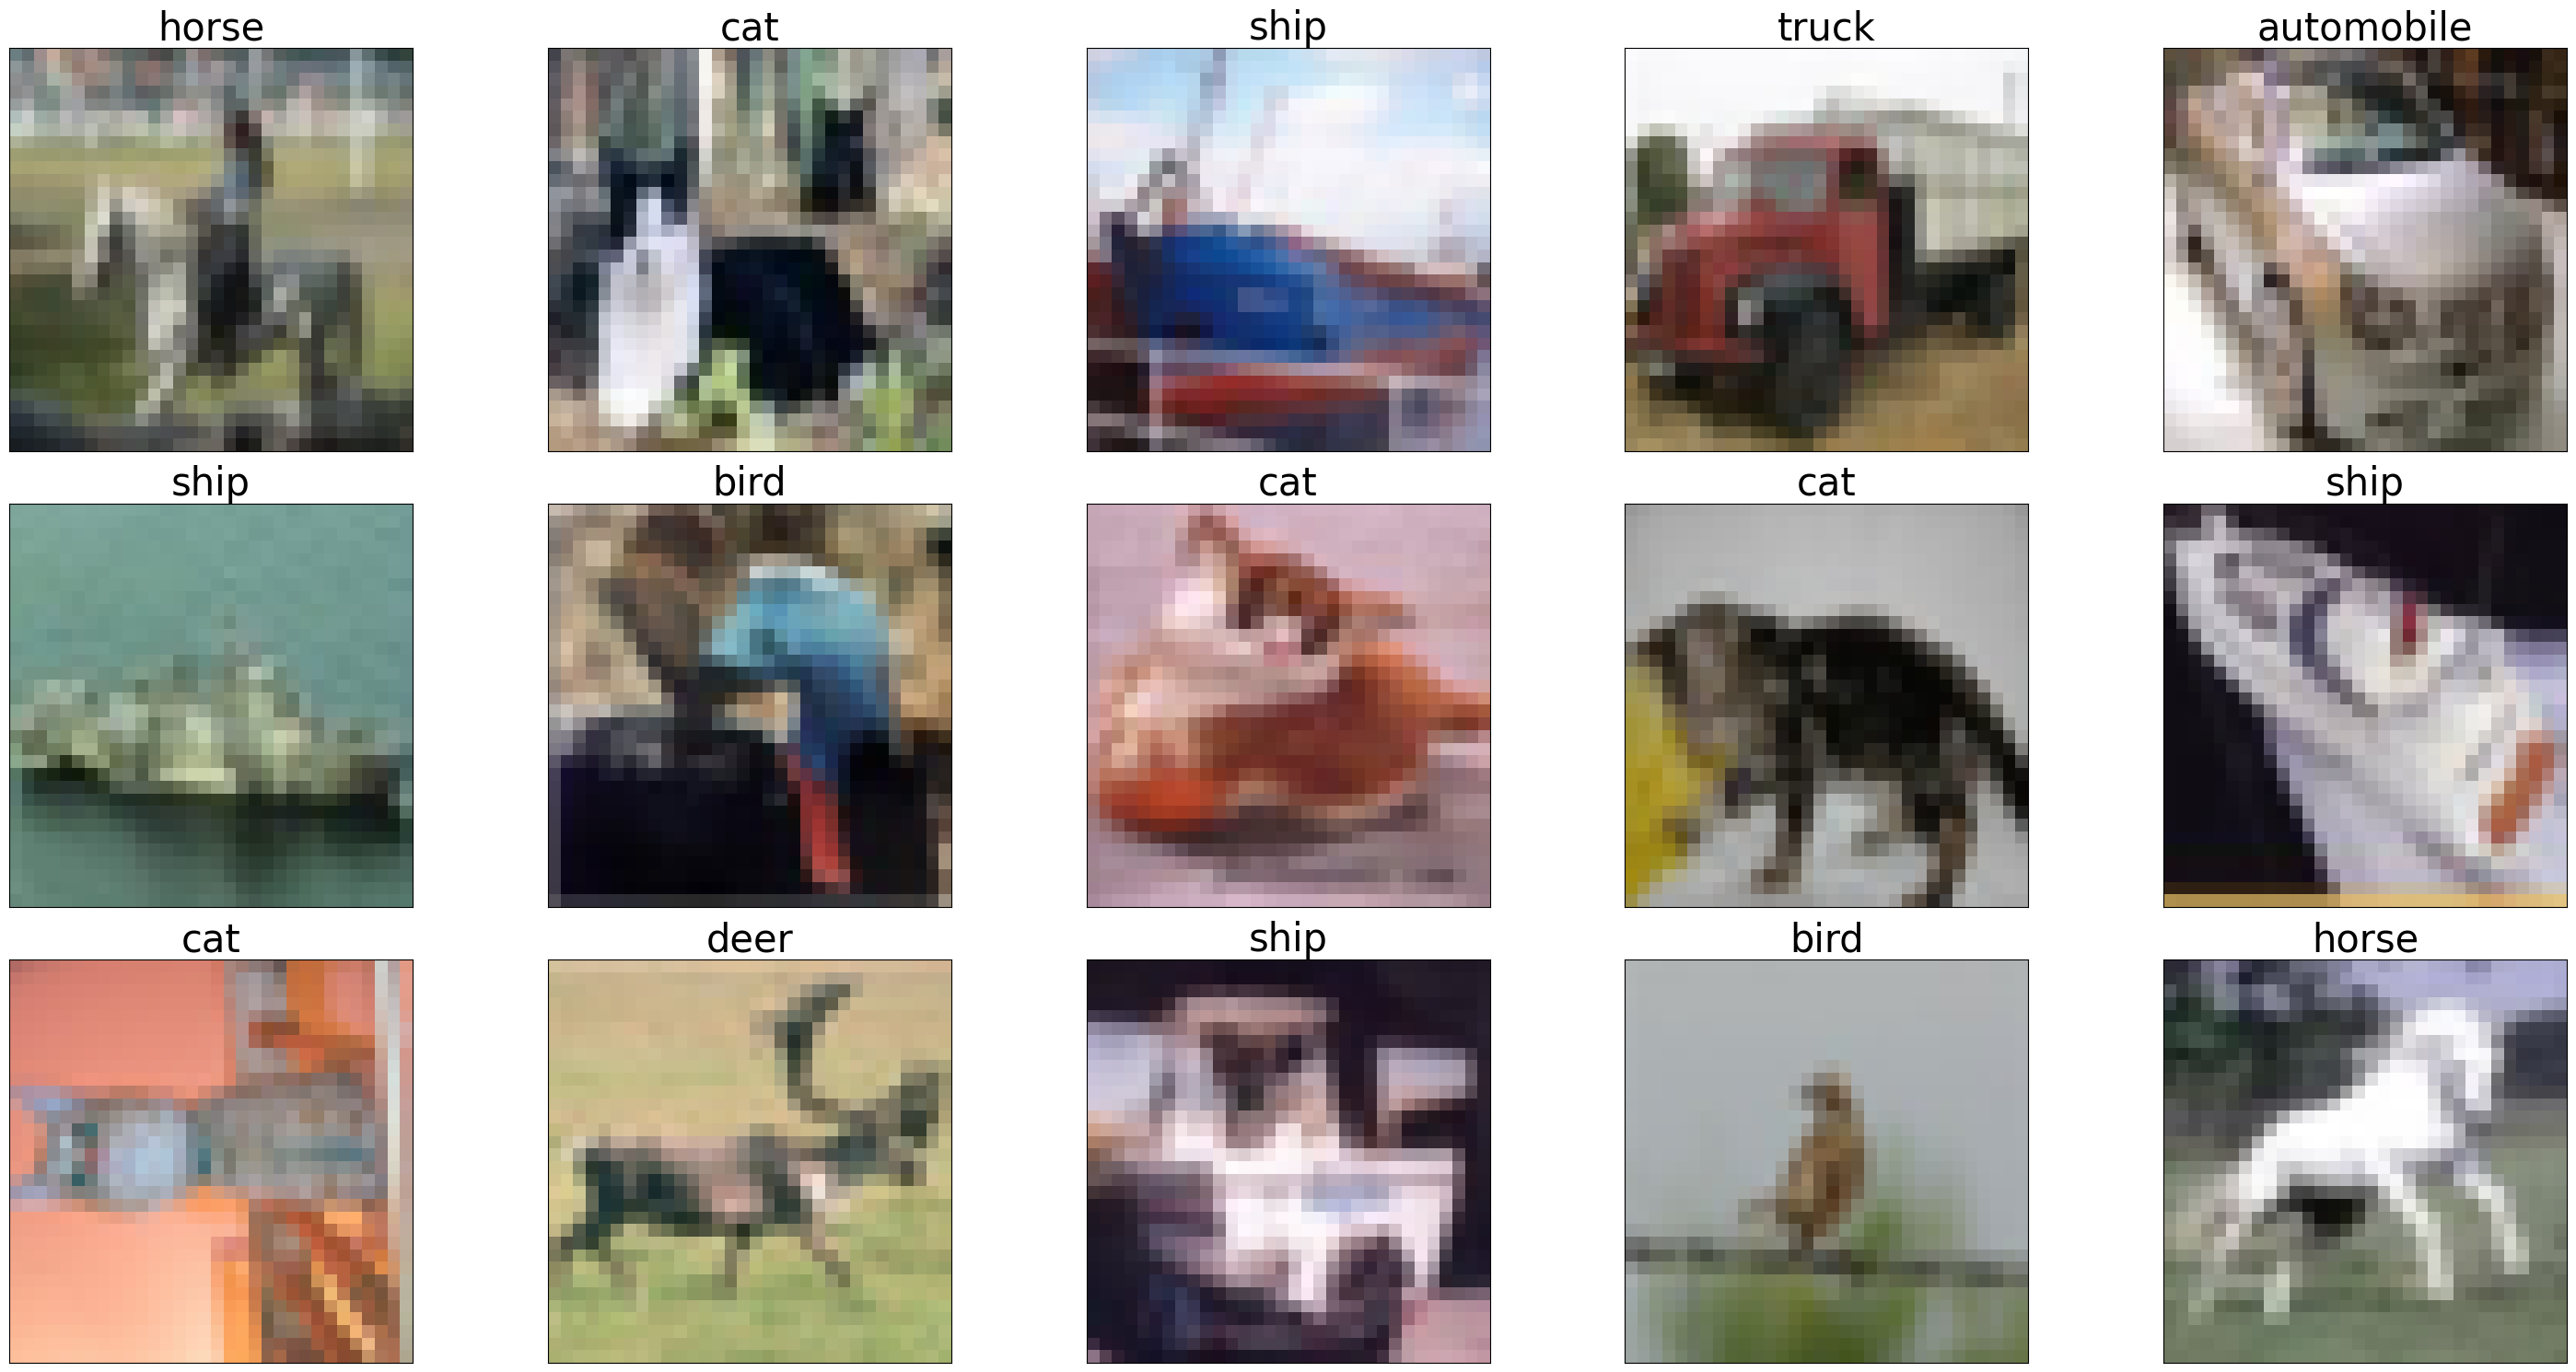

In [2]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms

# Definicja modelu
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x

# Ładowanie danych treningowych i testowych
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10(root='.', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='.', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
# Inicjalizacja modelu, funkcji straty i optymalizatora
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trening
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Ewaluacja na zbiorze testowym
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch [1/5], Loss: 1.3597
Epoch [2/5], Loss: 0.9139
Epoch [3/5], Loss: 0.7144
Epoch [4/5], Loss: 0.5763
Epoch [5/5], Loss: 0.4543
Test Accuracy: 75.93%


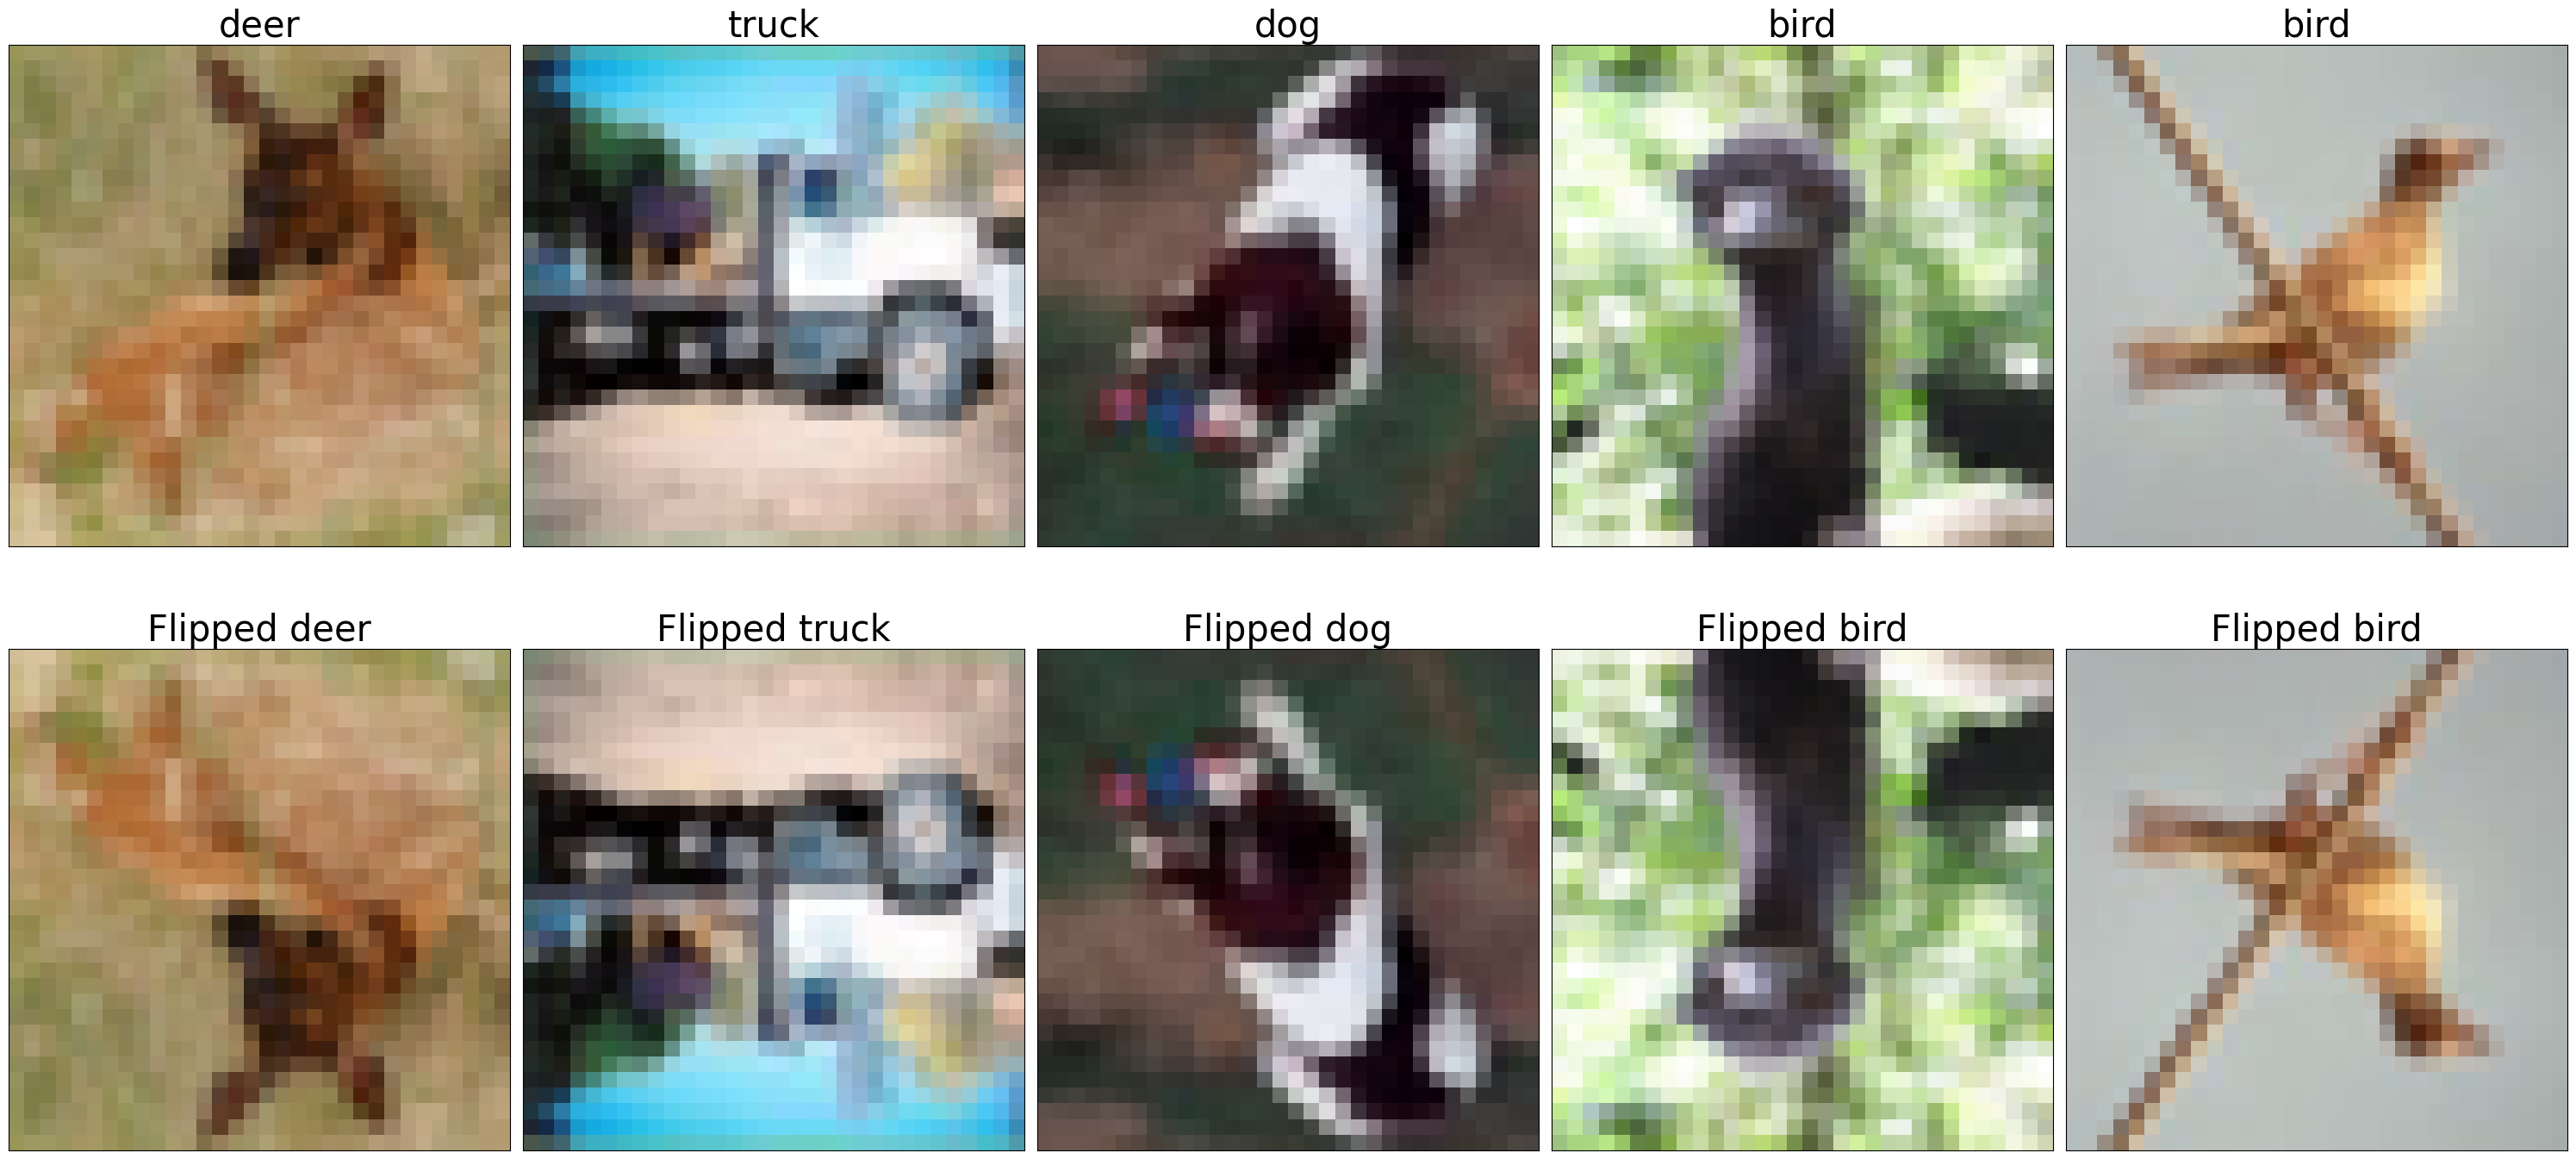

In [5]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [6]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

import torchvision.transforms as transforms

# Definicja augmentacji danych treningowych
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Ładowanie danych treningowych i testowych z augmentacją
train_dataset = CIFAR10(root='.', train=True, download=True, transform=transform_train)
test_dataset = CIFAR10(root='.', train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Inicjalizacja modelu, funkcji straty i optymalizatora
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trening
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Ewaluacja na zbiorze testowym
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch [1/5], Loss: 1.4096
Epoch [2/5], Loss: 1.0165
Epoch [3/5], Loss: 0.8554
Epoch [4/5], Loss: 0.7528
Epoch [5/5], Loss: 0.6800
Test Accuracy: 74.77%
